# Desarrollo Tarea 4

#### **Estudiantes:** 
* Omar David Toledo Leguizamón (202424446)
* Jose Miguel Alvearte (202010602)

Antes de entrar a los problemas de grafos, vamos a diseñar un conjunto de rutinas que nos permitirán visualizar los grafos

In [63]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_weighted_graph(edges, directed=True):
    """
    Plots a graph with curved edges and edge labels placed over the curves.
    
    Parameters:
    edges (list of tuples): Each tuple should contain three elements:
                            (source, destination, cost).
    
    Returns:
    None: Displays the graph plot with curved edges and edge labels.
    """
    # Create a directed or undirected graph based on the parameter
    G = nx.DiGraph() if directed else nx.Graph()
    rad = '0.3' if directed else '0'

    # Add edges to the graph from the provided edge list
    for edge in edges:
        source, destination, cost = edge
        G.add_edge(source, destination, weight=cost)  # Include the cost as edge weight

    # Use the circular layout algorithm for positioning the nodes
    pos = nx.circular_layout(G)

    plt.figure(figsize=(9, 6))  # Set the figure size

    # Draw the graph nodes
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue')

    # Draw the node labels
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

    # Draw the edges with curved connections and arrowheads
    if directed:
        nx.draw_networkx_edges(
            G, pos, 
            connectionstyle=f'arc3,rad={rad}',  # Curve the edges
            arrowstyle='-|>',  # Use arrowheads for directed edges
            arrowsize=20,  # Size of the arrowheads
        )
    else:
        nx.draw_networkx_edges(
            G, pos
        )


    # Create a dictionary for edge labels based on edge weights
    edge_labels = {(u, v): f'{G[u][v]["weight"]}' for u, v in G.edges()}

    # Draw the edge labels positioned along the curved edges
    nx.draw_networkx_edge_labels(
        G, pos, edge_labels=edge_labels,
        label_pos=0.5,  # Position labels at the midpoint of edges
        connectionstyle=f'arc3,rad={rad}',  # Curve the labels along with the edges
        rotate=False  # Do not rotate labels
    )

    plt.show()  # Display the graph

def plot_unweighted_graph(edges, directed=True):
    """
    Plots an unweighted graph with optional directionality.
    
    Parameters:
    edges (list of tuples): Each tuple should contain two elements:
                            (source, destination).
    
    Returns:
    None: Displays the unweighted graph plot.
    """
    # Create a directed or undirected graph based on the parameter
    G = nx.DiGraph() if directed else nx.Graph()
    rad = '0.1' if directed else '0'

    # Add edges to the graph from the provided edge list
    for edge in edges:
        source, destination = edge
        G.add_edge(source, destination)  # Add the edge without weights
    # Use the circular layout algorithm for positioning the nodes
    pos = nx.circular_layout(G)

    plt.figure(figsize=(9, 6))  # Set the figure size

    # Draw the graph nodes
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue')

    # Draw the node labels
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

    # Draw the edges with curved connections and arrowheads
    if directed:
        nx.draw_networkx_edges(
            G, pos, 
            connectionstyle=f'arc3,rad={rad}',  # Curve the edges
            arrowstyle='-|>',  # Use arrowheads for directed edges
            arrowsize=20  # Size of the arrowheads
        )
    else:
        nx.draw_networkx_edges(
            G, pos
        )

    plt.show()  # Display the graph

def plot_graph(edges, weighted=True, directed=True):
    """
    Wrapper function to plot either a weighted or unweighted graph.
    
    Parameters:
    edges (list of tuples): Edge list, either weighted or unweighted.
    weighted (bool): Indicates whether to plot a weighted graph.
    directed (bool): Indicates whether the graph is directed.
    
    Returns:
    None: Displays the graph plot.
    """
    if weighted: 
        plot_weighted_graph(edges, directed=directed)  # Call the function for weighted graphs
    else: 
        plot_unweighted_graph(edges, directed=directed)  # Call the function for unweighted graphs

def read_edge_list_from_file(filename):
    """
    Reads an edge list from a text file and returns it as a list of tuples.
    
    Parameters:
    filename (str): The path to the text file containing the edge list.
    
    Returns:
    list: A list of tuples where each tuple contains (source, destination, cost).
    """
    edges = []  # Initialize an empty list to store edges
    
    # Open the specified file in read mode
    with open(filename, 'r') as file:
        for line in file:  # Iterate over each line in the file
            parts = line.split()  # Split the line into parts
            if len(parts) == 3:  # Ensure there are exactly three parts
                source, destination, cost = map(int, parts)  # Convert strings to integers
                edges.append((source, destination, cost))  # Add the edge to the list
            if len(parts) == 2:  # Ensure there are exactly two parts
                source, destination = map(int, parts)  # Convert strings to integers
                edges.append((source, destination))  # Add the edge to the list
    
    return edges  # Return the list of edges


## Parte 1. Caminos de Costos mínimos

En el proyecto de JAVA adjunto, se definió el código que recibe la lista de aristas con sus pesos y obtiene la matriz de costos mínimos. Podemos probar el código con la matriz de ejemplo de 5 nodos para ver el resultado que se obtiene

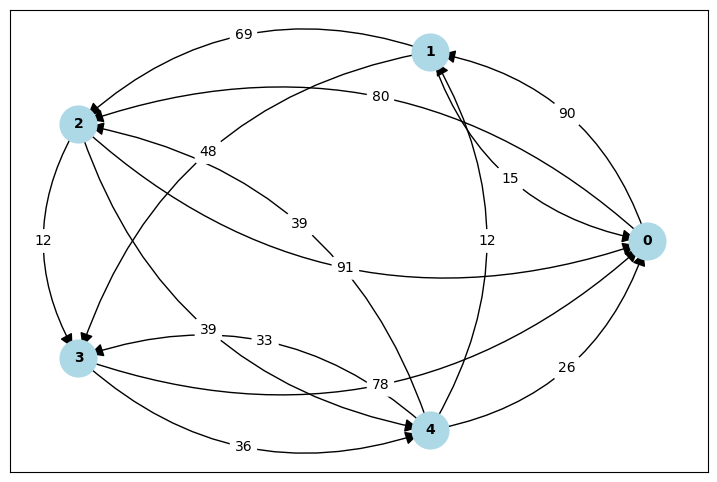

In [64]:
edges = read_edge_list_from_file('Java Projects\GraphsImplementations\data\distances5.txt')
plot_graph(edges,directed=True,weighted=True)

In [65]:
!cd "Java Projects\GraphsImplementations" && javac -d bin src/uniandes/algorithms/graphs/*.java && java -cp bin uniandes.algorithms.graphs.GraphImplementations minCost Dijkstra "data\distances5.txt" 1



Minimum Cost Matrix using Dijkstra: 

      |    0    1    2    3    4
---------------------------------
    0 |    0   90   80   92  119
    1 |   15    0   69   48   84
    2 |   65   51    0   12   39
    3 |   62   48   75    0   36
    4 |   26   12   39   33    0

Execution time in microseconds using Dijkstra for 5 nodes graph: 1586


In [66]:
!cd "Java Projects\GraphsImplementations" && javac -d bin src/uniandes/algorithms/graphs/*.java && java -cp bin uniandes.algorithms.graphs.GraphImplementations minCost BellmanFord "data\distances5.txt" 1



Minimum Cost Matrix using BellmanFord: 

      |    0    1    2    3    4
---------------------------------
    0 |    0   90   80   92  119
    1 |   15    0   69   48   84
    2 |   65   51    0   12   39
    3 |   62   48   75    0   36
    4 |   26   12   39   33    0

Execution time in microseconds using BellmanFord for 5 nodes graph: 386


In [67]:
!cd "Java Projects\GraphsImplementations" && javac -d bin src/uniandes/algorithms/graphs/*.java && java -cp bin uniandes.algorithms.graphs.GraphImplementations minCost FloydWarshall "data\distances5.txt" 1



Minimum Cost Matrix using FloydWarshall: 

      |    0    1    2    3    4
---------------------------------
    0 |    0   90   80   92  119
    1 |   15    0   69   48   84
    2 |   65   51    0   12   39
    3 |   62   48   75    0   36
    4 |   26   12   39   33    0

Execution time in microseconds using FloydWarshall for 5 nodes graph: 84


Dado que tenemos los archivos para verificar el resultado de las respuestas más grandes, diseñamos una función que realice dicha verificación

In [24]:
import numpy as np

def check_matrices_identical(file1, file2):
    """
    Loads two matrices from text files and checks if they are identical.

    Parameters:
        file1 (str): The name of the first file.
        file2 (str): The name of the second file.

    Returns:
        bool: True if the matrices are identical, False otherwise.
    """
    def load_matrix(filename):
        """Helper function to load a matrix from a file."""
        return np.loadtxt(filename, delimiter='\t')

    # Load both matrices
    matrix1 = load_matrix(file1)
    matrix2 = load_matrix(file2)

    if not np.array_equal(matrix1, matrix2):
        print("Matrices are different. Locations of differences:")
    else:
        print('Matrices are equal')
    
    # Create a boolean array that is True where elements differ
    differences = matrix1 != matrix2
    
    # Get the indices of the differing elements
    differing_indices = np.argwhere(differences)

    for index in differing_indices:
        row, col = index
        print(f"Difference at (row {row}, column {col}): {matrix1[row, col]} != {matrix2[row, col]}")


Vamos a generar las salidas para cada conjunto de datos

In [25]:
#Solucionamos los problemas con Floyd-Warshall

!cd "Java Projects\GraphsImplementations" && javac -d bin src/uniandes/algorithms/graphs/*.java && java -cp bin uniandes.algorithms.graphs.GraphImplementations minCost FloydWarshall "data\distancesDisconnected.txt" 0
!cd "Java Projects\GraphsImplementations" && javac -d bin src/uniandes/algorithms/graphs/*.java && java -cp bin uniandes.algorithms.graphs.GraphImplementations minCost FloydWarshall "data\distances5.txt" 0
!cd "Java Projects\GraphsImplementations" && javac -d bin src/uniandes/algorithms/graphs/*.java && java -cp bin uniandes.algorithms.graphs.GraphImplementations minCost FloydWarshall "data\distances100.txt" 0
!cd "Java Projects\GraphsImplementations" && javac -d bin src/uniandes/algorithms/graphs/*.java && java -cp bin uniandes.algorithms.graphs.GraphImplementations minCost FloydWarshall "data\distances1000.txt" 0

Execution time in microseconds using FloydWarshall for 4 nodes graph: 109
Execution time in microseconds using FloydWarshall for 5 nodes graph: 100
Execution time in microseconds using FloydWarshall for 100 nodes graph: 19476
Execution time in microseconds using FloydWarshall for 1000 nodes graph: 3097361


In [26]:
#Solucionamos los problemas con Dijkstra

!cd "Java Projects\GraphsImplementations" && javac -d bin src/uniandes/algorithms/graphs/*.java && java -cp bin uniandes.algorithms.graphs.GraphImplementations minCost Dijkstra "data\distancesDisconnected.txt" 0
!cd "Java Projects\GraphsImplementations" && javac -d bin src/uniandes/algorithms/graphs/*.java && java -cp bin uniandes.algorithms.graphs.GraphImplementations minCost Dijkstra "data\distances5.txt" 0
!cd "Java Projects\GraphsImplementations" && javac -d bin src/uniandes/algorithms/graphs/*.java && java -cp bin uniandes.algorithms.graphs.GraphImplementations minCost Dijkstra "data\distances100.txt" 0
!cd "Java Projects\GraphsImplementations" && javac -d bin src/uniandes/algorithms/graphs/*.java && java -cp bin uniandes.algorithms.graphs.GraphImplementations minCost Dijkstra "data\distances1000.txt" 0

Execution time in microseconds using Dijkstra for 4 nodes graph: 2030
Execution time in microseconds using Dijkstra for 5 nodes graph: 2893
Execution time in microseconds using Dijkstra for 100 nodes graph: 73473
Execution time in microseconds using Dijkstra for 1000 nodes graph: 64510402


In [29]:
#Solucionamos los problemas con BellmanFord

!cd "Java Projects\GraphsImplementations" && javac -d bin src/uniandes/algorithms/graphs/*.java && java -cp bin uniandes.algorithms.graphs.GraphImplementations minCost BellmanFord "data\distancesDisconnected.txt" 0
!cd "Java Projects\GraphsImplementations" && javac -d bin src/uniandes/algorithms/graphs/*.java && java -cp bin uniandes.algorithms.graphs.GraphImplementations minCost BellmanFord "data\distances5.txt" 0
!cd "Java Projects\GraphsImplementations" && javac -d bin src/uniandes/algorithms/graphs/*.java && java -cp bin uniandes.algorithms.graphs.GraphImplementations minCost BellmanFord "data\distances100.txt" 0
!cd "Java Projects\GraphsImplementations" && javac -d bin src/uniandes/algorithms/graphs/*.java && java -cp bin uniandes.algorithms.graphs.GraphImplementations minCost BellmanFord "data\distances1000.txt" 0

Execution time in microseconds using BellmanFord for 4 nodes graph: 182
Execution time in microseconds using BellmanFord for 5 nodes graph: 459
Execution time in microseconds using BellmanFord for 100 nodes graph: 1702462
Execution time in microseconds using BellmanFord for 1000 nodes graph: 16554092653


Verificamos que las soluciones sean correctas

In [27]:
#Checking Floyd-Warshall Solutions

path = 'Java Projects\GraphsImplementations'
check_matrices_identical(path+'\data\distances1000FloydWarshallsolution.txt',path+'\data\distances1000_costosminimos.txt')
check_matrices_identical(path+'\data\distances100FloydWarshallsolution.txt',path+'\data\distances100_costosminimos.txt')

Matrices are equal
Matrices are different. Locations of differences:
Difference at (row 0, column 1): 11.0 != 4.0
Difference at (row 0, column 2): 7.0 != 4.0
Difference at (row 0, column 3): 8.0 != 6.0
Difference at (row 0, column 4): 9.0 != 4.0
Difference at (row 0, column 5): 7.0 != 5.0
Difference at (row 0, column 6): 4.0 != 3.0
Difference at (row 0, column 7): 4.0 != 2.0
Difference at (row 0, column 8): 7.0 != 4.0
Difference at (row 0, column 9): 6.0 != 5.0
Difference at (row 0, column 10): 11.0 != 1.0
Difference at (row 0, column 11): 9.0 != 6.0
Difference at (row 0, column 13): 5.0 != 3.0
Difference at (row 0, column 14): 9.0 != 4.0
Difference at (row 0, column 15): 5.0 != 4.0
Difference at (row 0, column 16): 6.0 != 5.0
Difference at (row 0, column 17): 4.0 != 3.0
Difference at (row 0, column 18): 9.0 != 3.0
Difference at (row 0, column 19): 9.0 != 6.0
Difference at (row 0, column 20): 11.0 != 2.0
Difference at (row 0, column 21): 7.0 != 2.0
Difference at (row 0, column 22): 7.0

In [28]:
#Checking Dijkstra Solutions

path = 'Java Projects\GraphsImplementations'
check_matrices_identical(path+'\data\distances1000Dijkstrasolution.txt',path+'\data\distances1000_costosminimos.txt')
check_matrices_identical(path+'\data\distances100Dijkstrasolution.txt',path+'\data\distances100_costosminimos.txt')

Matrices are equal
Matrices are different. Locations of differences:
Difference at (row 0, column 1): 11.0 != 4.0
Difference at (row 0, column 2): 7.0 != 4.0
Difference at (row 0, column 3): 8.0 != 6.0
Difference at (row 0, column 4): 9.0 != 4.0
Difference at (row 0, column 5): 7.0 != 5.0
Difference at (row 0, column 6): 4.0 != 3.0
Difference at (row 0, column 7): 4.0 != 2.0
Difference at (row 0, column 8): 7.0 != 4.0
Difference at (row 0, column 9): 6.0 != 5.0
Difference at (row 0, column 10): 11.0 != 1.0
Difference at (row 0, column 11): 9.0 != 6.0
Difference at (row 0, column 13): 5.0 != 3.0
Difference at (row 0, column 14): 9.0 != 4.0
Difference at (row 0, column 15): 5.0 != 4.0
Difference at (row 0, column 16): 6.0 != 5.0
Difference at (row 0, column 17): 4.0 != 3.0
Difference at (row 0, column 18): 9.0 != 3.0
Difference at (row 0, column 19): 9.0 != 6.0
Difference at (row 0, column 20): 11.0 != 2.0
Difference at (row 0, column 21): 7.0 != 2.0
Difference at (row 0, column 22): 7.0

In [78]:
#Checking BellmanFord Solutions 

path = 'Java Projects\GraphsImplementations'
check_matrices_identical(path+'\data\distances1000BellmanFordsolution.txt',path+'\data\distances1000_costosminimos.txt')
check_matrices_identical(path+'\data\distances100BellmanFordsolution.txt',path+'\data\distances100_costosminimos.txt')

Matrices are equal
Matrices are different. Locations of differences:
Difference at (row 0, column 1): 11.0 != 4.0
Difference at (row 0, column 2): 7.0 != 4.0
Difference at (row 0, column 3): 8.0 != 6.0
Difference at (row 0, column 4): 9.0 != 4.0
Difference at (row 0, column 5): 7.0 != 5.0
Difference at (row 0, column 6): 4.0 != 3.0
Difference at (row 0, column 7): 4.0 != 2.0
Difference at (row 0, column 8): 7.0 != 4.0
Difference at (row 0, column 9): 6.0 != 5.0
Difference at (row 0, column 10): 11.0 != 1.0
Difference at (row 0, column 11): 9.0 != 6.0
Difference at (row 0, column 13): 5.0 != 3.0
Difference at (row 0, column 14): 9.0 != 4.0
Difference at (row 0, column 15): 5.0 != 4.0
Difference at (row 0, column 16): 6.0 != 5.0
Difference at (row 0, column 17): 4.0 != 3.0
Difference at (row 0, column 18): 9.0 != 3.0
Difference at (row 0, column 19): 9.0 != 6.0
Difference at (row 0, column 20): 11.0 != 2.0
Difference at (row 0, column 21): 7.0 != 2.0
Difference at (row 0, column 22): 7.0

De ese modo, podemos organizar los tiempos de ejecución en microsegundos ($\mu s$) en la siguiente tabla:

| **Entrada** | **Floyd-Warshall** | **BellmanFord** | **Dijkstra** |
|-|-|-|-|
| distanceDisconnected | 109 | 182 | 2030 |
| distance5 | 100 | 459 | 2893 |
| distance100 | 19476 | 1702462 | 73473 |
| distance1000 | 3097361 | 16554092653 | 64510402 |

Lo cual es equivalente a la siguiente en formato de horas, minutos y segundos:

| **Entrada**          | **Floyd-Warshall**   | **BellmanFord**   | **Dijkstra**        |
|----------------------|----------------------|-------------------|---------------------|
| distanceDisconnected | 00:00:00             | 00:00:00          | 00:00:00            |
| distance5            | 00:00:00             | 00:00:00          | 00:00:00            |
| distance100          | 00:00:00             | 00:00:01          | 00:00:00            |
| distance1000         | 00:00:03             | 04:35:54          | 00:01:04            |





## Parte 2. Componentes Conectados

En el proyecto adjunto, se realizó una implmentación de BFS para determinar los componentes conectados de un grafo. Se utilizará como principal ejemplo el siguiente grafo:

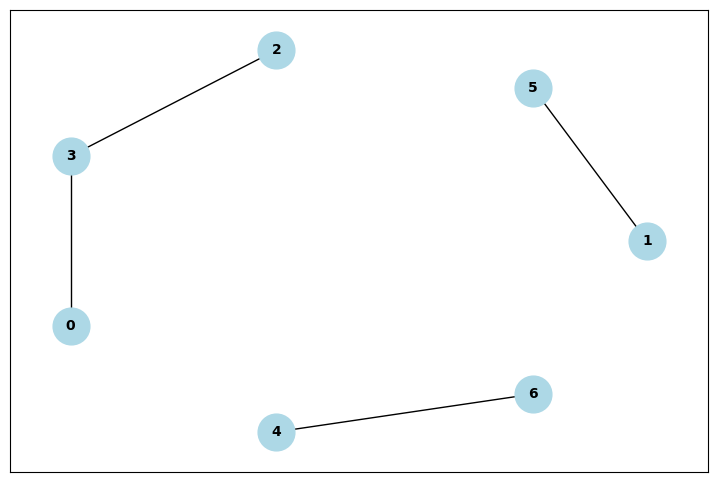

In [79]:
edges = read_edge_list_from_file('Java Projects\GraphsImplementations\data\componentsExample.txt')
plot_graph(edges,directed=False,weighted=False)

In [80]:
!cd "Java Projects\GraphsImplementations" && javac -d bin src/uniandes/algorithms/graphs/*.java && java -cp bin uniandes.algorithms.graphs.GraphImplementations components BFS "data\componentsExample.txt" 1


Components found using BFS: {{0,3,2},{1,5},{4,6}} 

Execution time in microseconds using BFS for 7 nodes graph: 712


Con el fin de validar visualmente el algoritmo, se buscará implementar con dos grafos adicionales. Uno conexo y uno donde cada eje esta conectado unica y exclusivamente a si mismo.

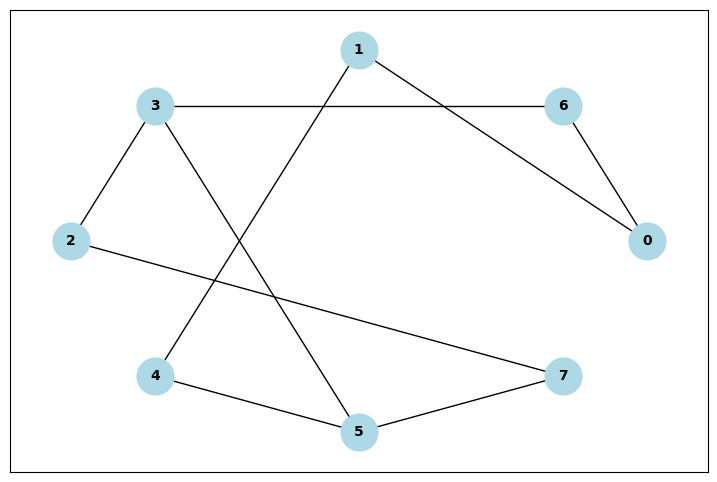

In [81]:
edges = read_edge_list_from_file('Java Projects\GraphsImplementations\data\componentsConnected.txt')
plot_graph(edges,directed=False,weighted=False)

In [82]:
!cd "Java Projects\GraphsImplementations" && javac -d bin src/uniandes/algorithms/graphs/*.java && java -cp bin uniandes.algorithms.graphs.GraphImplementations components BFS "data\componentsConnected.txt" 1


Components found using BFS: {{0,6,1,3,4,2,5,7}} 

Execution time in microseconds using BFS for 8 nodes graph: 1359


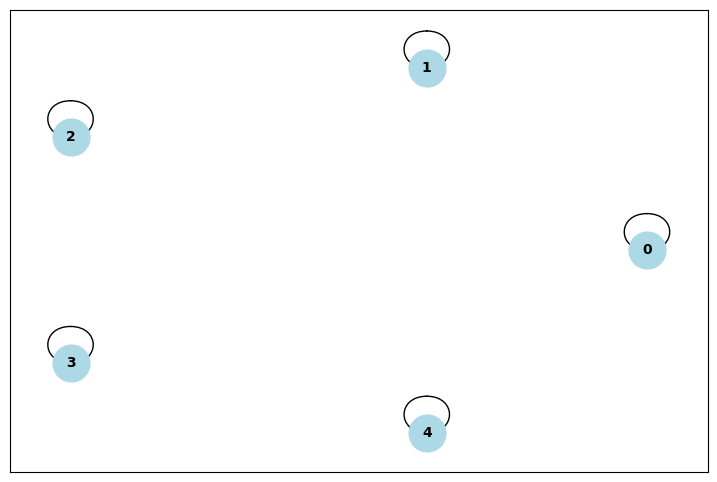

In [83]:
edges = read_edge_list_from_file('Java Projects\GraphsImplementations\data\componentsIsolated.txt')
plot_graph(edges,directed=False,weighted=False)

In [84]:
!cd "Java Projects\GraphsImplementations" && javac -d bin src/uniandes/algorithms/graphs/*.java && java -cp bin uniandes.algorithms.graphs.GraphImplementations components BFS "data\componentsIsolated.txt" 1


Components found using BFS: {{0},{1},{2},{3},{4}} 

Execution time in microseconds using BFS for 5 nodes graph: 578
